<h1>Trabalho Prático 1</h1>
<h2>Nome: Sérgio José de Sousa</h2>

- Redes Neuronais + Backpropagation

Neste trabalho você irá implementar uma rede neuronal com três camadas:

1. Camada de entrada: cada unidade representa uma dimensão do dado de entrada.

2. Camada oculta: cada unidade representa uma transformação a partir das unidades de entrada.

3. Camada de saída: cada unidade representa a chance da saída correspondente ser a correta.

Você irá utilizar a função Sigmóide para obter não-linearidade. Além disso, a função de perda a ser minimizada é a seguinte: <i>binary_crossentropy</i>

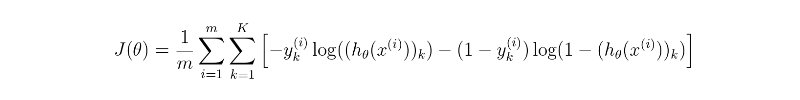

onde m é a quantidade de entradas no treino, K é o número de saídas possíveis,  representa a saída correta de cada classe k em cada entrada (i), e similarmente representa a saída dada pela rede neuronal.

O dado a ser utilizado está anexado. Trata-se de 5000 entradas, onde cada entrada refere-se a um dígito escrito manualmente (i.e., MNIST dataset). Dessa forma, m=5000 e K=10. Cada entrada é dada por uma matriz de dimensões 28 por 28, ou seja, um vetor de 784 dimensões. A primeira coluna do arquivo sempre é o rótulo do dígito correto.

A rede neuronal a ser implementada deverá ter 784 unidades de entrada e 10 unidades de saída. Em seus experimentos, você deverá variar o número de unidades na camada oculta (25, 50, 100).

Além disso, você deverá comparar os seguintes algoritmos de cálculo de gradiente:

1. Gradient Descent: o gradiente é calculado após cada época (após as 5000 entradas serem processadas).

2. Stochastic Gradient Descent: o gradiente é calculado após cada entrada.

3. Mini-Batch: o gradiente é calculado após um certo número de entradas (considere 10 e 50).

Por fim, você também deverá variar a taxa de aprendizado: 0.5, 1, 10.

O documento a ser entregue deverá apresentar o resultado de seus experimentos. Ou seja, deverá apresentar discussão da variação do número de unidades na camada oculta para cada um dos três algoritmos de cálculo de gradiente. Você deverá apresentar gráficos mostrando a convergência do erro empírico para cada situação (unidades na camada oculta, algoritmo de cálculo do gradiente, taxa de aprendizado). Você deverá deixar claras todas as hipóteses que julgar serem pertinentes.

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import gc
import time
import sys

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras.optimizers import SGD
# StratifiedKFold To make k-fold Cross Validation
from sklearn.model_selection import StratifiedKFold

import cv2

# Seed for random values
seed = 7
np.random.seed(seed)

# Loading data set with 5000 samples of MNIST
dataset = np.loadtxt("data_tp1", delimiter=',')
# Separetes the data set into data and labels
X_train = dataset[:,1:len(dataset[0])]
Y_train = dataset[:,:1]
# Vector to kfold function
Y_labels = np.reshape(Y_train, len(Y_train))

Using TensorFlow backend.


In [4]:
# Normalize the data
x_train = X_train/255
# Convert the labels into categorical data.
y_train = np_utils.to_categorical(Y_train)

# Number of inputs
nPixels = X_train.shape[1]
# Number of outputs
nClasses = y_train.shape[1]
# Number of data sambles
nSamples = len(y_train)

In [5]:
# Define Model
def baseline_model(_larningRate, _units):
    # Define custom optimizer
    sgd = SGD(lr=_larningRate)
    
    # Create model
    model = Sequential()
    # Input with nPixels units, fallowing of hidden layer with _units and sigmoid activation
    model.add(Dense(_units, input_dim=nPixels, kernel_initializer='normal', activation='sigmoid'))      
    # nClasses units and sigmoid activation
    model.add(Dense(nClasses, kernel_initializer='normal', activation='sigmoid'))
    # Compile model with binary crossentropy loss function and sgd with optimizer
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy']) #categorical_crossentropy binary_crossentropy
    return model

In [6]:
# Train de model
def Train(verbose = False):
    global cvScorescores
    global history
    global model
    
    # Create KFold
    kfold = StratifiedKFold(n_splits=nSplits, shuffle=True, random_state=seed)

    # Train the Data with each split of k-fold
    for train, test in kfold.split(x_train, Y_labels):
        # Create model
        model = baseline_model(larningRate, units)
        # Train the data and save history
        history = model.fit(x_train[train], y_train[train], 
                  validation_data=(x_train[test], y_train[test]), epochs=nEpochs, batch_size = nBatch, verbose=0)
        # Scores
        scores = model.evaluate(x_train[test], y_train[test], verbose=0)
        cvScores.append(scores[1] * 100)
        # print kfold score
        if verbose:
            print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        
    # Print mean score and standard deviation
    if verbose:
        print("%.2f%% (+/- %.2f%%)" % (np.mean(cvScores), np.std(cvScores)))
    return np.mean(cvScores), np.std(cvScores)

#Plot a Graphic with accuracy and loss of test and train
def PlotHistory(_history, info=''):
    # plotting the metrics
    fig = plt.figure()
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)#bbox=props
    fig.suptitle(info, fontsize=14, fontweight='bold', y=1.2, 
                 bbox=props, verticalalignment='center')
    fig.subplots_adjust(top=0.85)
    
    plt.subplot(2,1,1)
    plt.title('model accuracy')
    
    plt.plot(_history.history['acc'])
    plt.plot(_history.history['val_acc'])
    
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right', )
   
    plt.subplot(2,1,2)
    plt.plot(_history.history['loss'])
    plt.plot(_history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()

# Predict a image
def PredictImg(path):
    img = cv2.imread(path)
    img = cv2.resize(img, (28, 28))

    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    arr2 = abs(gray_image-255.0)/255

    plt.subplot(221)
    print arr2.shape
    plt.imshow(arr2, cmap=plt.get_cmap('gray'))

    #show the plot
    plt.show()

    arr = np.array(arr2).reshape((28,28,1))
    arr = np.expand_dims(arr2, axis=0)
    o = arr2.reshape(arr.shape[0], nPixels).astype('float32')

    print(model.predict(o))
    print(model.predict_classes(o))
    
def PredictVector():
    id = 2
    aa = np.expand_dims(x_train[id], axis=0)

    print("label => ", y_train[id])

    print(model.predict(aa))
    print(model.predict_classes(aa))

In [7]:
#List to automatic hyperparameter test
'''
1. Learning rate = 0.5, 1, 10
2. Hidden Layer = 25, 50, 100
3. Optimizer = Gradiente Descent, Stochastic Gradiente Descent, Mini-Batch (10-50)
'''
lHiddenLayer = [25, 50, 100]
lLr = [0.5, 1, 10]
lBatch = [1, 10, 50, 5000]

/home/sergio/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


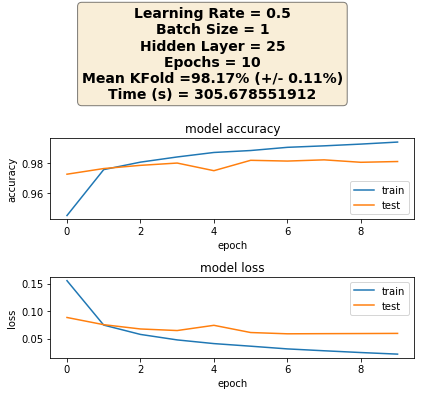

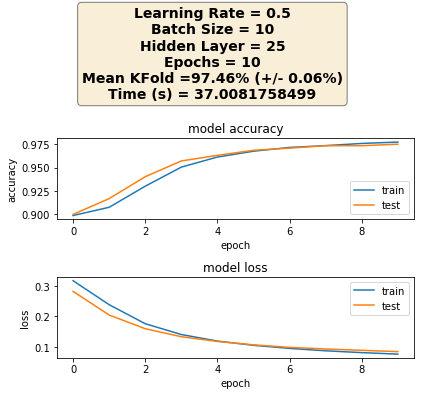

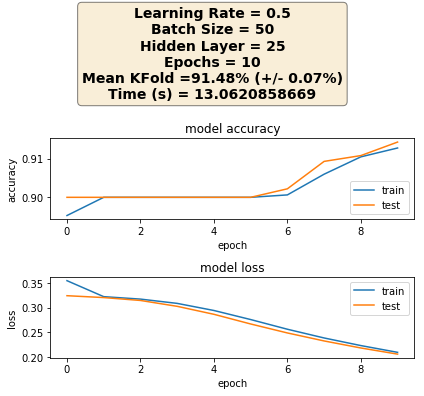

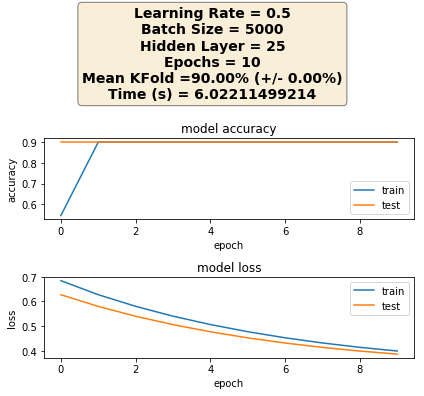

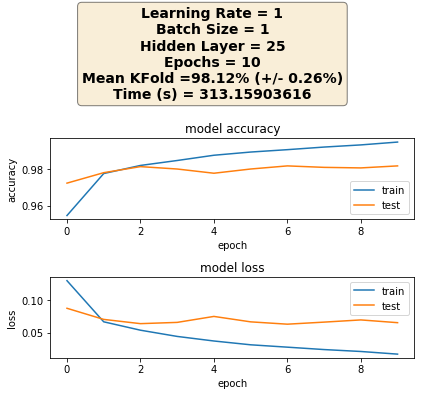

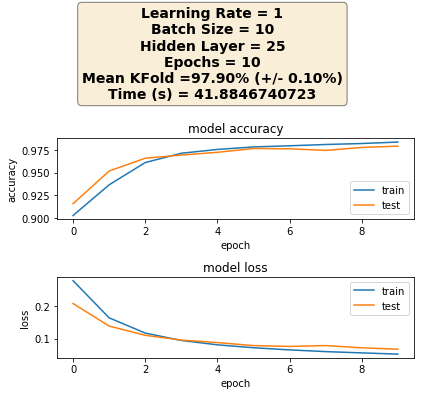

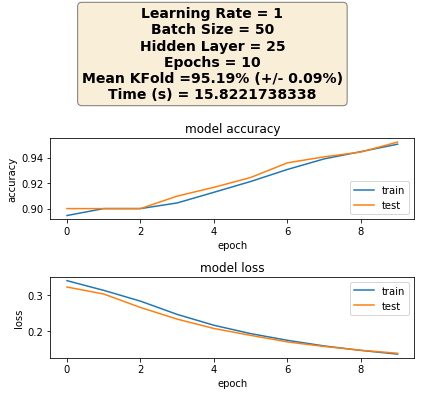

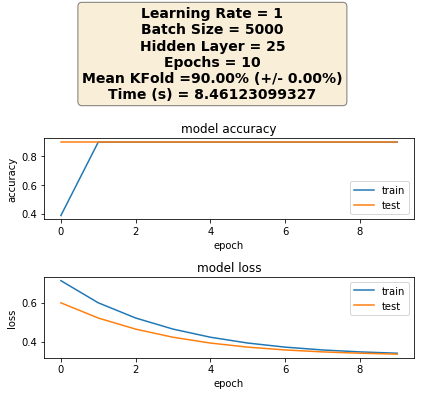

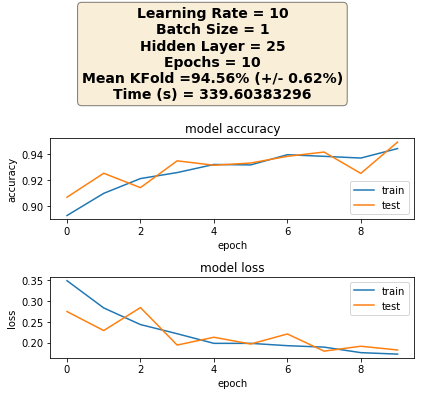

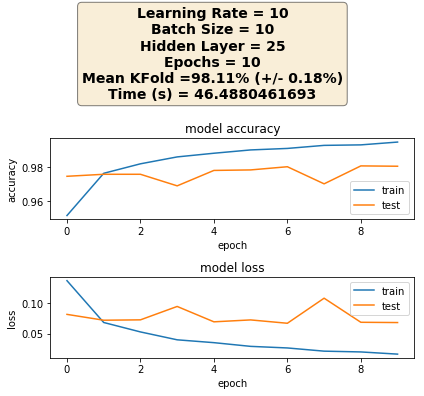

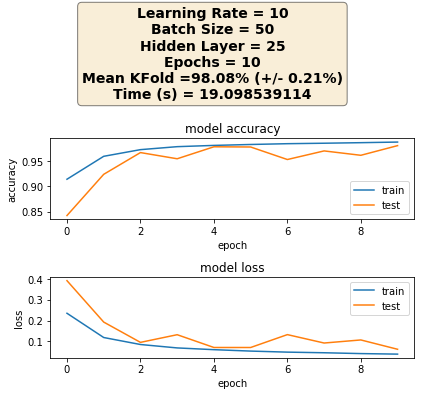

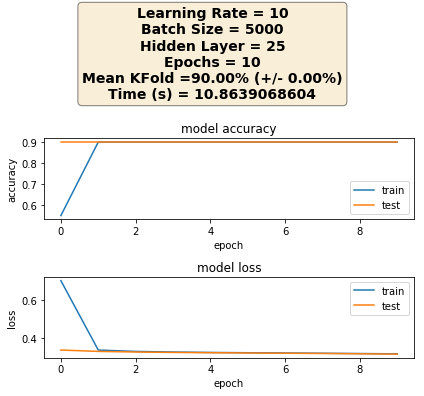

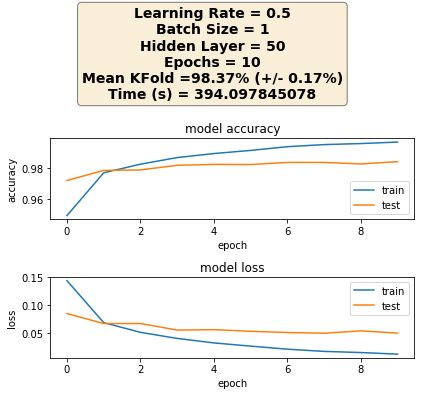

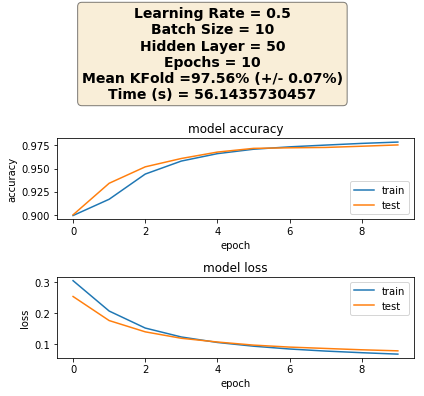

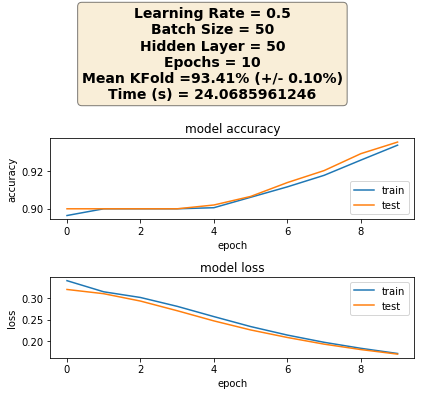

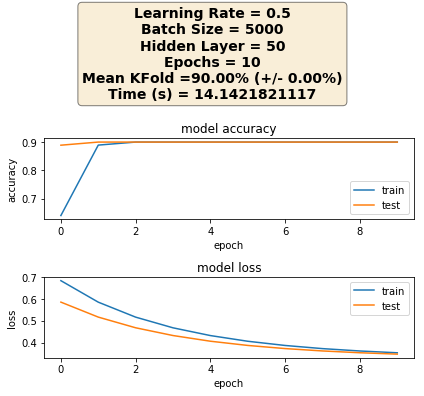

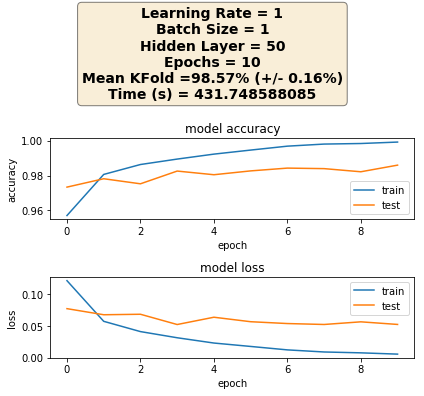

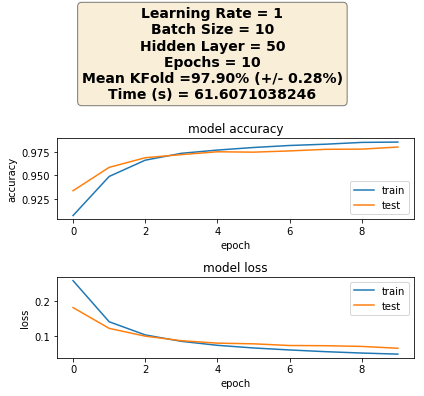

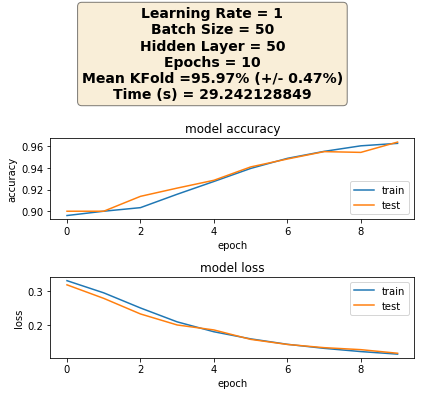

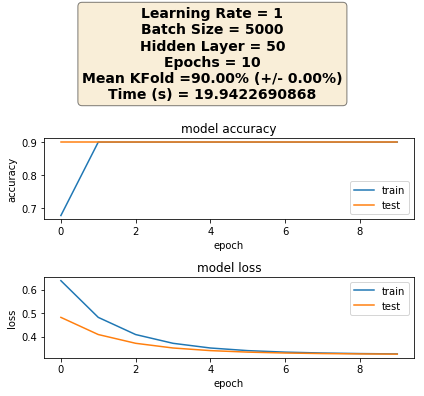

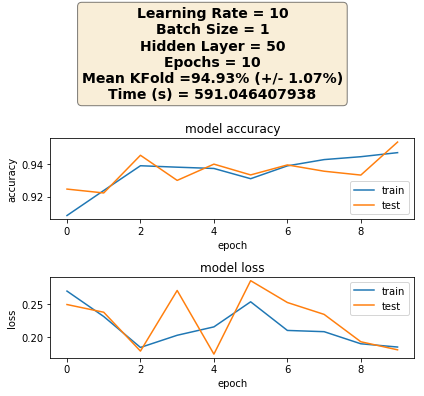

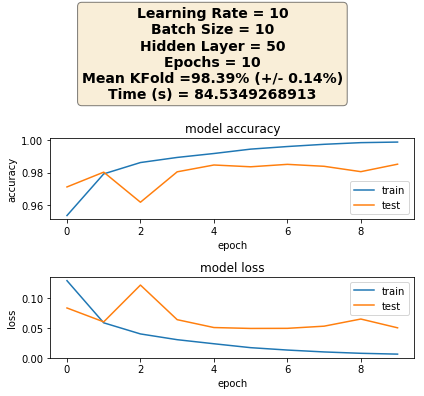

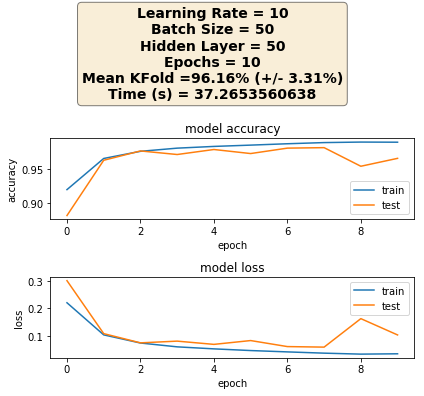

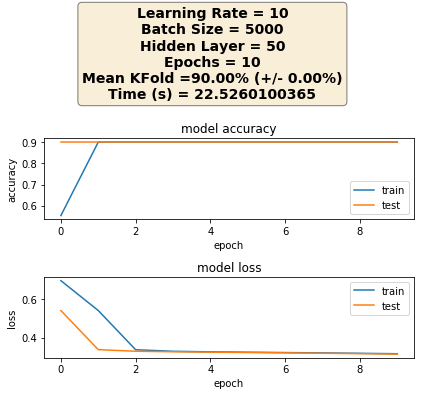

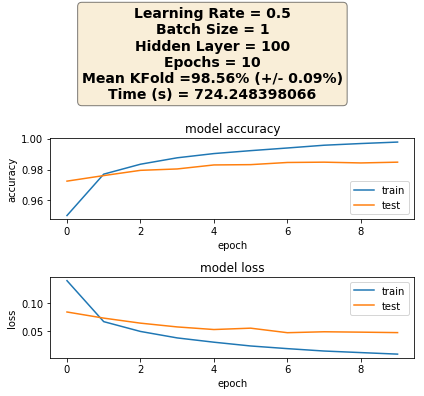

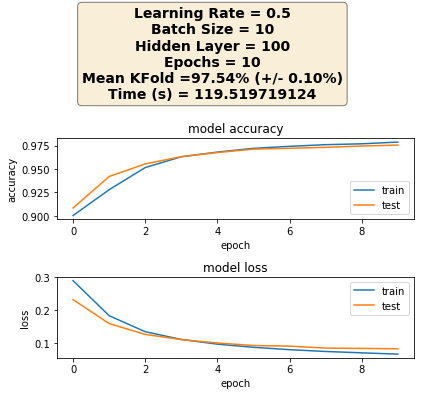

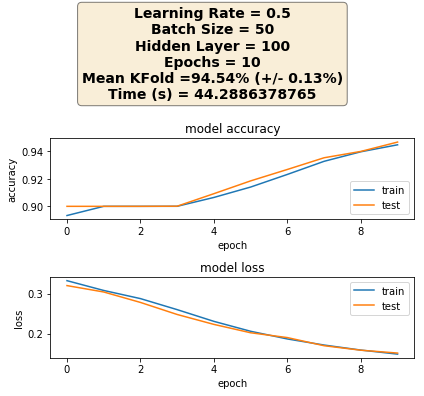

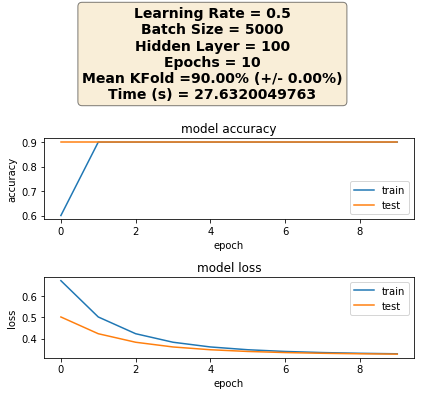

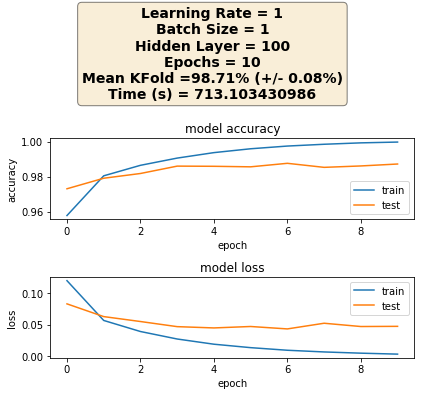

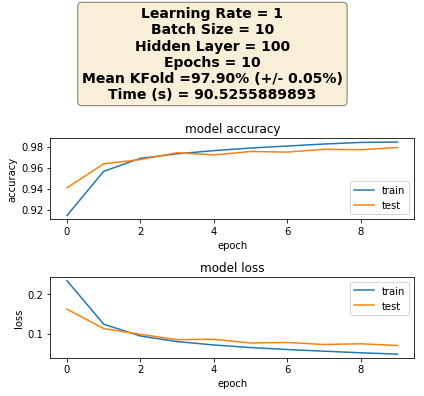

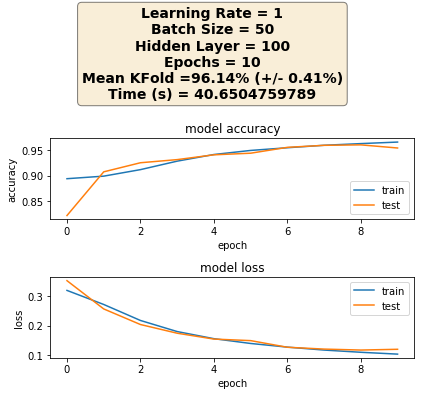

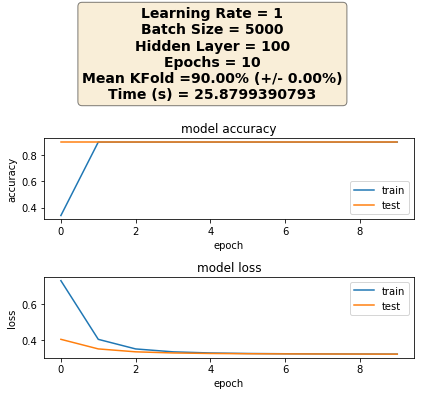

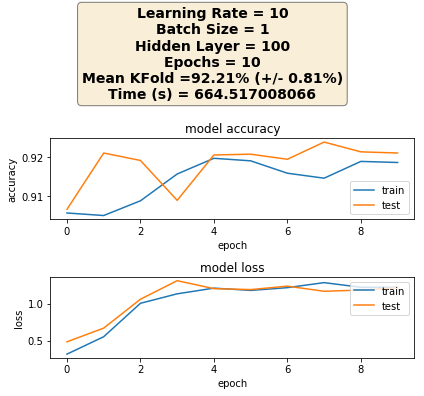

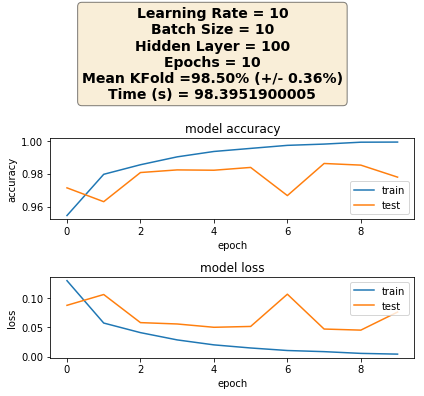

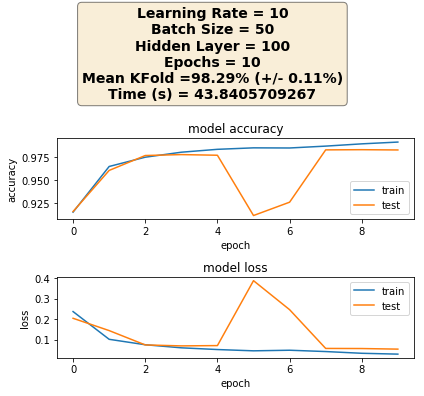

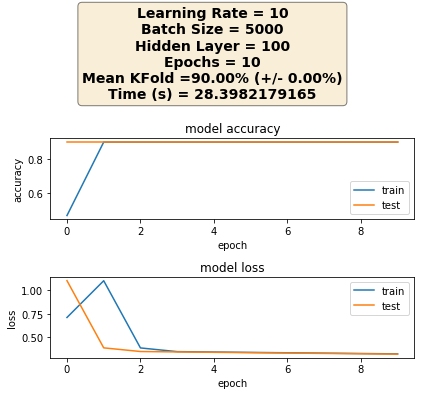

In [9]:
qtdMax = len(lHiddenLayer) * len(lLr) * len(lBatch)
qtd = 0

for hidden in lHiddenLayer:
    for lr in lLr:
        for batch in lBatch:    
            ### Hyperparameters ##
            # Learning Rate of model (0.5, 1, 10)
            larningRate = lr
            # Number of units 1st hidden layer (25, 50, 100)
            units = hidden
            # Optimizer = In this casa just change the size of the batch, 
            # 1: Gradiente Descent (batch = nSamples), 
            # 2: Stochastic Gradiente Descent (batch = 1), 
            # 3: Mini-Batch (10) 
            # 4: Mini-Batch (50)
            nBatch = batch
            # Number of epochs
            nEpochs = 10
            # Number of splits of k-fold
            nSplits = 5
            # K-fold Scores
            cvScores = []
            # History of train
            history = None
            # Model NN
            model = None
            
            currentModel = str('[{0}] / {1}'.format(qtd+1, qtdMax)+" - "
                       +"MODEL = ["
                       +"Learning Rate = " + str(lr) +" - "
                       +"Batch Size = "+ str(batch) +" - "
                       +"Hidden Layer = "+str(hidden)+ " - "
                       +"Epochs = "+str(nEpochs)+ "]                    ")
            print '{0}\r'.format(currentModel),
            
            start = time.time()
            mean, std = Train()
            end = time.time() 
            
            strTitle = ("Learning Rate = " + str(lr) +"\n"
                       +"Batch Size = "+ str(batch) +"\n"
                       +"Hidden Layer = "+str(hidden)+ "\n"
                       +"Epochs = "+str(nEpochs)+ "\n"
                       +"Mean KFold =%.2f%% (+/- %.2f%%)" % (mean, std)+ "\n"
                       +"Time (s) = "+str(end - start))
            PlotHistory(history, strTitle)
            
            model = None
            gc.collect()
            qtd += 1

<h2>Analisando Resultados</h2>

<h3>Este trabalho considera as seguintes observações:</h3>
<br/>
<b>Batch</b>
1. Batch 1 = Stochastic Gradient Descent<br/>
2. Batch 10 = Mini-Batch = 10<br/>
3. Batch 50 = Mini-Batch = 50<br/>
4. Batch 5000 = Gradient Descent<br/>

<b>Learning Rate</b> varia entre 0.5, 1 e 10<br/>
<b>Hidden Layer</b> variando entre 25, 50 e 100 neurônios<br/>
<b>Epoch</b> fixada em 10<br/>

Os modelos propostos utilizam cross validation calculando a acurácia média e o desvio padrão dos k-folds. (5 folds)

<h3>Variando mini batch</h3>
Ao utilizar Stochastic Gradient Descent com batch igual 1 verificou-se que a rede manteve uma alta taxa na acurácia porém não convergiu para learning rate 0.5 e 1, já com learning rate 10 a rede convergiu, oscilando no teste tanto do loss quanto da acurácia que se manteve em 94%.

Com mini batch de tamanho 10 e learning rate 0.5 e 1 a taxa de acurácia foi de 97% convergindo com sucesso. Mas com learning rate 10 além da rede não convergir o teste do loss e da acurácia oscilaram, teve uma acurácia média de 98%.

Com mini batch de tamanho 50 e learning rate 0.5 e 1 a rede converge, acurácia e o loss crescem mais lentamente que nos outros modelos variando a acurácia entre 91% e 97%. Já com learning rate igual a 10  a rede tende a convergir, o crescimento não é tão lento mas oscila um pouco, tendo uma média de 97% na acurácia.

Com Gradient Descent, ou seja, mini batch igual a todos registros a rede rapidamente adquire uma acurácia de 90% e permanece assim, saturando independente dos demais hiperparâmetros.

Quanto menor o valor do batch mais lento é para treinar o modelo.

<h3>Variando neurônios na camada oculta</h3>
Analisando a quantidade de neurônios na camada oculta, pode-se concluir que ao aumentarmos a quantidade de neurônios obtivemos um crescimento mais lento da acurácia e uma redução mais lenta no loss, necessitando de mais épocas para convergir. Ou seja os modelos com 100 unidades foram mais lentos que os modelos com 50 e 25. Pelos testes é possível concluir que 25 neurônios são suficientes para esses dados.

<h3>Variando learning rate</h3>
Com learning rate igual a 0.5 os modelos tiveram bom comportamento, praticamente sem oscilação nos testes e com alta taxa na acurácia. Ao aumentarmos o learning rate temos modelos com testes instáveis, criando modelos que oscilando ao longo das épocas. No caso mais extremo, com learning rate igual a 10 temos mais oscilações e um caso especial quando o mini batch igual a 1 o modelo chega a convergir apesar das oscilações.

<h3>Melhor Resultado</h3>
O melhor resultado foi obtido com os seguintes hiperparâmetros:
1. Mini batch = 10
2. Neurônios na hidden layer = 25
3. Learning Rate = 10

10 épocas foram suficientes para o modelo convergir com taxa de acurácia de 97% sem oscilar. Aumentando essa quantidade verificou-se que o modelo começa a ter overfitting. Caso reduza o learning rate é necessário aumentar a quantidade de épocas para o modelo convergir, o mesmo vale para aumentar a quantidade de neurônios. 

acc: 97.85%
acc: 97.94%
acc: 98.05%
acc: 97.83%
acc: 97.94%
97.92% (+/- 0.08%)


5888

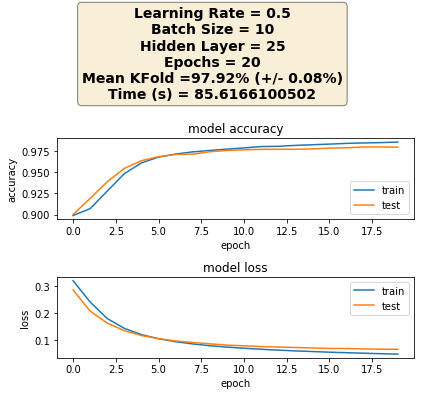

In [15]:
### Melhor Resultado ###
### Hyperparameters ###
larningRate, units, nBatch, nEpochs, nSplits = 0.5, 25, 10, 20, 5
cvScores, history, model = [], None, None

start = time.time()
mean, std = Train(verbose=True)
end = time.time() 

strTitle = ("Learning Rate = " + str(larningRate) +"\n"+"Batch Size = "+ str(nBatch) +"\n"+"Hidden Layer = "+str(units)+ "\n"+"Epochs = "+str(nEpochs)+ "\n"+"Mean KFold =%.2f%% (+/- %.2f%%)" % (mean, std)+ "\n"+"Time (s) = "+str(end - start))

PlotHistory(history, strTitle)

model = None
gc.collect()